In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Harris corner detector

## Mathematical overview
Consider shifting the window W by (u,v):
- Compare each pixel before and after by summing up the squared differences (SSD)
- This defines an SSD “error” E(u,v):
\begin{equation*}
E(u,v) = 
\sum_{x,y} \underbrace{w(x,y)}_{\text{window function}}.
[\underbrace{I(x+u, y+v)}_{\text{shifted intensity}} - \underbrace{I(x,y)}_{\text{intensity}}]^2
\end{equation*}


This formulation is to find the difference in intensity for a sift of (u,v) in a image.<br>
We are happy if this error is high

Then, apply Taylor Series expansion:
\begin{equation*}
I(x + u, y + v) 
\approx
I(x, y) + 
\frac{\partial I}{\partial x} u +
\frac{\partial I}{\partial y} v
\end{equation*}

\begin{equation*}
I(x + u, y + v) 
\approx
I(x, y) + 
\begin{bmatrix}
I_x & I_y 
\end{bmatrix}
.
\begin{bmatrix}
u \\
v
\end{bmatrix}
\end{equation*}

\begin{equation*}
\Rightarrow
E(u,v)
\approx
\sum_{x,y} w(x,y).[I(x,y) + u.I_x + v.I_y - I(x,y)]^2
\end{equation*}

\begin{equation*}
\Rightarrow
E(u,v)
\approx
\sum_{x,y} w(x,y).[u.I_x + v.I_y]^2
\end{equation*}

\begin{equation*}
\Rightarrow
E(u,v)
\approx
\begin{bmatrix}
u & v
\end{bmatrix}
. M .
\begin{bmatrix}
u \\
v
\end{bmatrix}
\quad \text{with}
\quad
M = 
\sum_{x,y} w(x,y).
\begin{bmatrix}
I_x I_x & I_x I_y \\
I_x I_y & I_y I_y
\end{bmatrix}
\end{equation*}

\begin{align*}
I_x: \text{image derivatives in x} \\
I_y: \text{image derivatives in y} \\
\text{These can be easily found using cv.Sobel(src, ddepth, dx, dy, ksize)}
\end{align*}

Calculate the response of the corner detector:
\begin{equation*}
R = \det(M) - k.(trace(M))^2
\end{equation*}
Where:
\begin{align*}
\det(M) = \lambda_1 \lambda_2 \\
trace(M) = \lambda_1 + \lambda_2 \\
\lambda_1 \text{ and } \lambda_2 \text{ are the eigenvalues of M}
\end{align*}

<u>Note:</u><br>
The <strong>eigenvectors</strong> of a matrix A are the vectors v that satisfy:
\begin{equation*}
Av = \lambda v
\text{ with v is a non zero vector}
\end{equation*}

\begin{equation*}
\Leftrightarrow
(A - \lambda I) v = 0
\end{equation*}

λ is <strong>eigenvalue</strong> of a matrix A if:

\begin{equation*}
\det(A - \lambda I) = 0
\end{equation*}

Depending on the value obtained by this response, is possible to determine if a region contains a flat region, an edge, or a corner.
\begin{align*}
\text{When |R| is small} \Leftrightarrow \lambda_1 \text{ and } \lambda_2 \text{ are small}, \text{ the region is flat.} \\
\text{When R < 0>} \Leftrightarrow \lambda_1 \gg \lambda_2 \text{ or vice versa}, \text{ the region is edge.} \\
\text{When R is large} \Leftrightarrow \lambda_1 \text{ and } \lambda_2 \text{ are large and } \lambda_1 \sim \lambda_2, \text{ the region is a corner.} \\
\end{align*}

## Implementation

In [2]:
def findHarrisCorners(img, window_size, k, threshold):

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    img_gaussian = cv2.GaussianBlur(gray,(3,3),0)
        
    height = img.shape[0]   #.shape[0] outputs height 
    width = img.shape[1]    #.shape[1] outputs width, shape[2] outputs color channels of image
    matrix_R = np.zeros((height,width))
    
    #   Step 1 - Calculate the image derivatives in x and y (Ix, Iy)
    Ix = cv2.Sobel(src=img_gaussian, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5)
    Iy = cv2.Sobel(src=img_gaussian, ddepth=cv2.CV_64F, dx=0, dy= 1, ksize=5)
    # dy, dx = np.gradient(gray)

    #   Step 2 - Calculate square of derivatives and second derivatives (Ix2, Iy2, Ixy)
    Ix2 = np.square(Ix)
    Iy2 = np.square(Iy)
    Ixy = Ix * Iy

    offset = int( window_size / 2 )
    #   Step 3 - For each pixel, Sum of squares of intensities of partial derevatives (Sx2, Sy2 e Sxy)
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):

            # values of sliding window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1

            Sx2 = np.sum(Ix2[start_y : end_y, start_x : end_x])
            Sy2 = np.sum(Iy2[start_y : end_y, start_x : end_x])
            Sxy = np.sum(Ixy[start_y : end_y, start_x : end_x])

            #   Step 4 - Define the matrix M(x,y)=[[Sx2,Sxy],[Sxy,Sy2]]
            M = np.array([[Sx2,Sxy],[Sxy,Sy2]])

            #   Step 5 - Calculate the response function ( R=det(M)-k(Trace(M))^2 )
            det = np.linalg.det(M)
            tr = np.matrix.trace(M)
            R = det - k*(tr**2)
            matrix_R[y-offset, x-offset] = R
    
    #   Step 6 - Find local maxima (Non-maxima suppression) of matrix_R
    plt.figure(figsize=(15, 15))
    plt.title("matrix R")
    plt.imshow(matrix_R, cmap='gray')
    
    matrix_R = nonMaxSuppression(matrix_R)
    plt.figure(figsize=(15, 15))
    plt.title("matrix R after local maxima")
    plt.imshow(matrix_R, cmap='gray')

    #   Step 7 - Apply a threshold
    cv2.normalize(matrix_R, matrix_R, 0, 1, cv2.NORM_MINMAX)
    num_of_corners = 0
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            value = matrix_R[y, x]
            if value > threshold:
                cv2.circle(img, (x,y), 2, (0,255,0), 2)
                num_of_corners = num_of_corners + 1
                
    plt.figure(figsize=(15, 15))
    plt.title("Manually implemented Harris detector")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    print("Count: ", num_of_corners)

#### Local maximum

In [3]:
def nonMaxSuppression(gray_img):
    height = gray_img.shape[0]
    width = gray_img.shape[1]
    for a in range(1, height - 1, 2):
        for b in range(1, width - 1, 2):
            nonMaxSuppressionAt(gray_img, a, b)
    return gray_img

def nonMaxSuppressionAt(gray_img, i, j):
    max_intensity = getLocalMax(gray_img, i, j)
    for k in [-1, 0, 1]:
        for l in [-1, 0, 1]:
            if (gray_img[i+k][j+l] == max_intensity):
                continue
            else:
                gray_img[i+k][j+l] = 0

def getLocalMax(gray_img, i, j):
    max_intensity = 0
    for k in [-1, 0, 1]:
        for l in [-1, 0, 1]:
            if (max_intensity < gray_img[i+k][j+l]):
                max_intensity = gray_img[i+k][j+l]
    return max_intensity

Count:  119


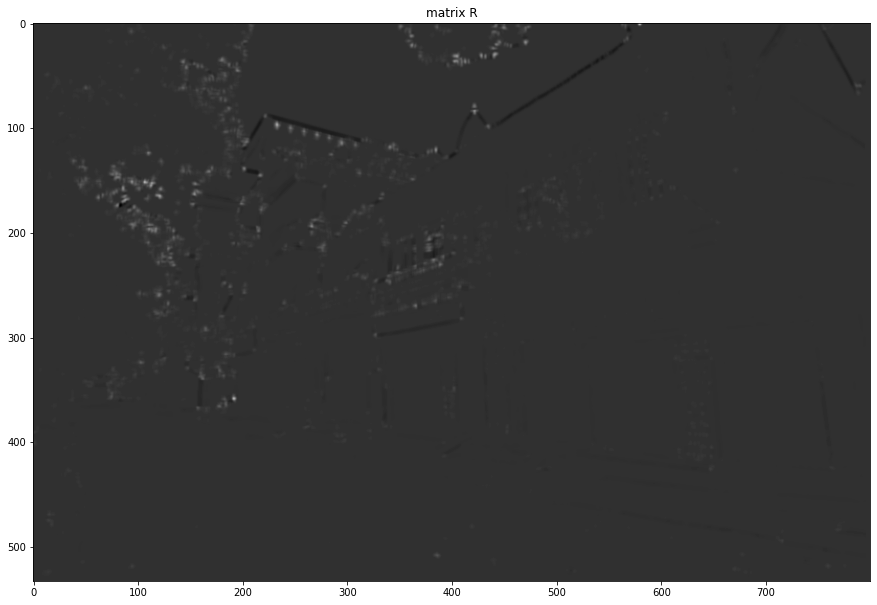

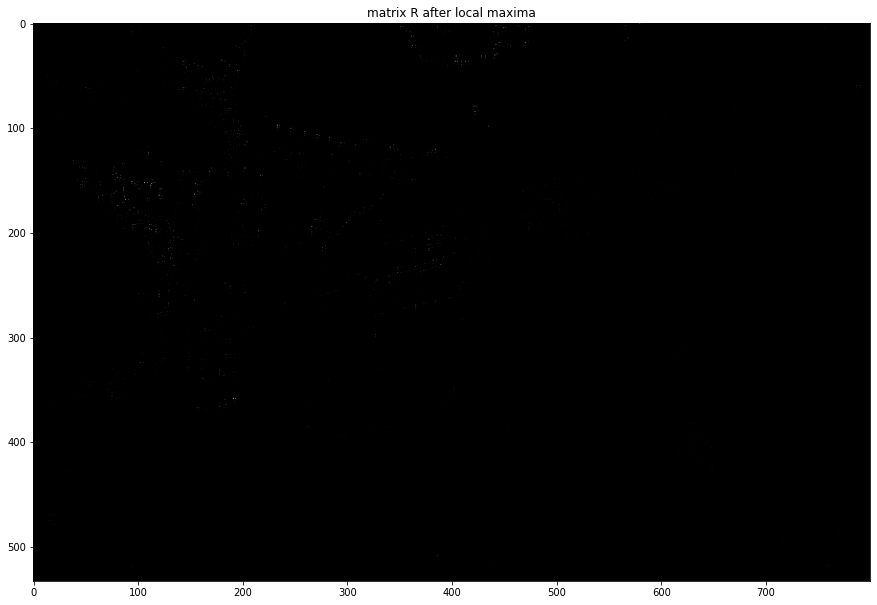

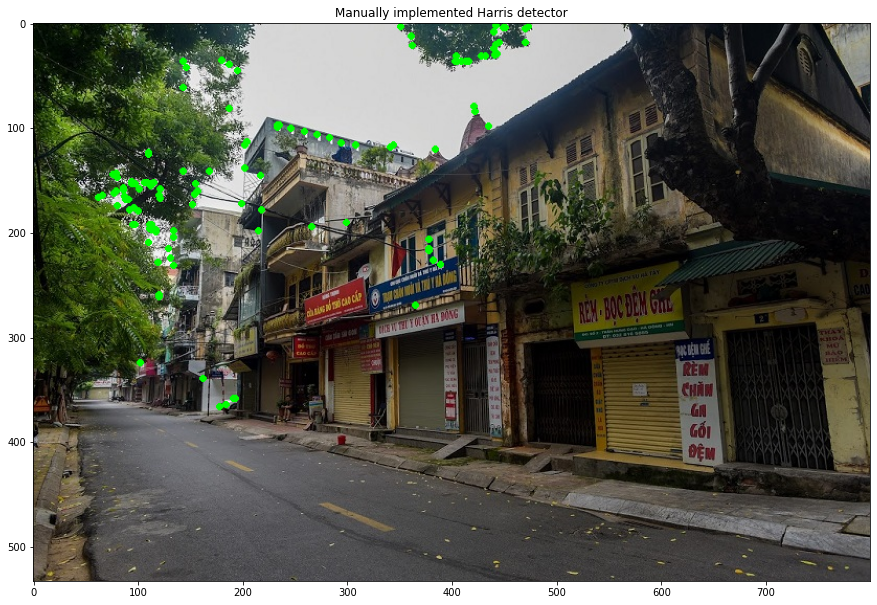

In [4]:
img = cv2.imread("../hanoi.jpg")
findHarrisCorners(img, 5, 0.04, 0.2)

## Harris corner detector in OpenCV

OpenCV has the function <strong>cv.cornerHarris()</strong> with arguments:

* <i>img</i> - Input image. It should be grayscale and float32 type.
* <i>blockSize</i> - It is the size of neighbourhood considered for corner detection
* <i>ksize</i> - Aperture parameter of the Sobel derivative used.
* <i>k</i> - Free parameter in the <i>response of the corner detector</i> equation.

In [5]:
def applyHarrisCorners(img, window_size, ksize, k, threshold):
    # block_size <=> window_size
    # ksize <=> size of Sobel kernel
    # k <=> k

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    dst = cv2.cornerHarris(gray_img, window_size, ksize, k)
    detector_responses = cv2.dilate(dst, None)
    
    img[detector_responses > threshold * detector_responses.max()] = [0,255,0]
    num_of_corners = np.sum(detector_responses > threshold * detector_responses.max())

    plt.figure(figsize=(15, 15))
    plt.title("openCV Harris detector")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    print("Count: ", num_of_corners)

Count:  330


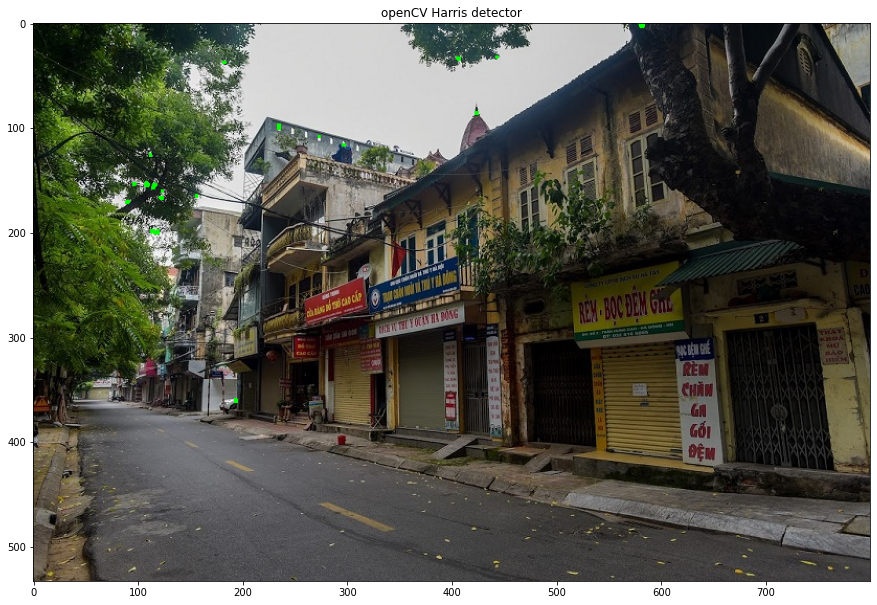

In [6]:
img = cv2.imread("../hanoi.jpg")
applyHarrisCorners(img, 5, 5, 0.04, 0.2)

## Harris corner detector with pyramid images

In [7]:
img = cv2.imread("../hanoi.jpg")
imgDownScale = cv2.pyrDown(img)
imgUpScale = cv2.pyrUp(img)

Count:  119


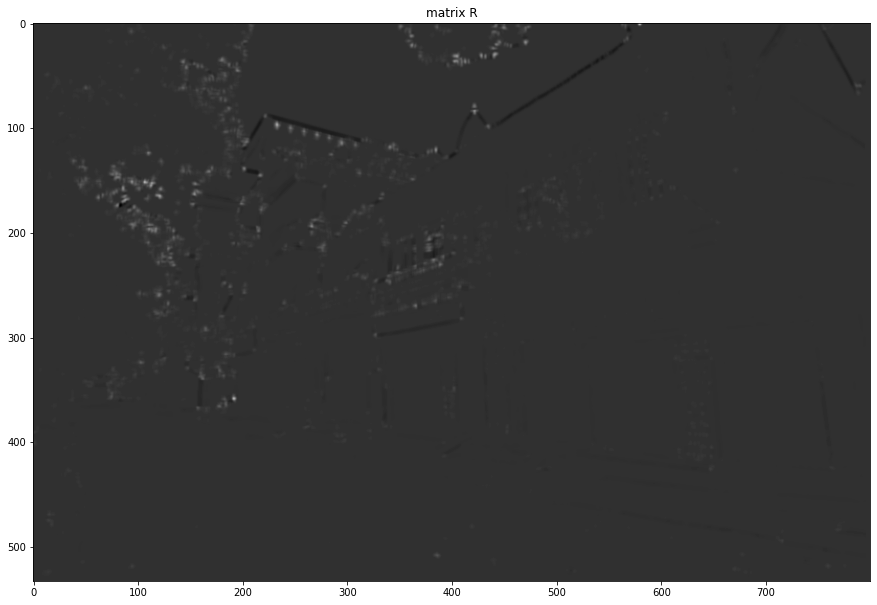

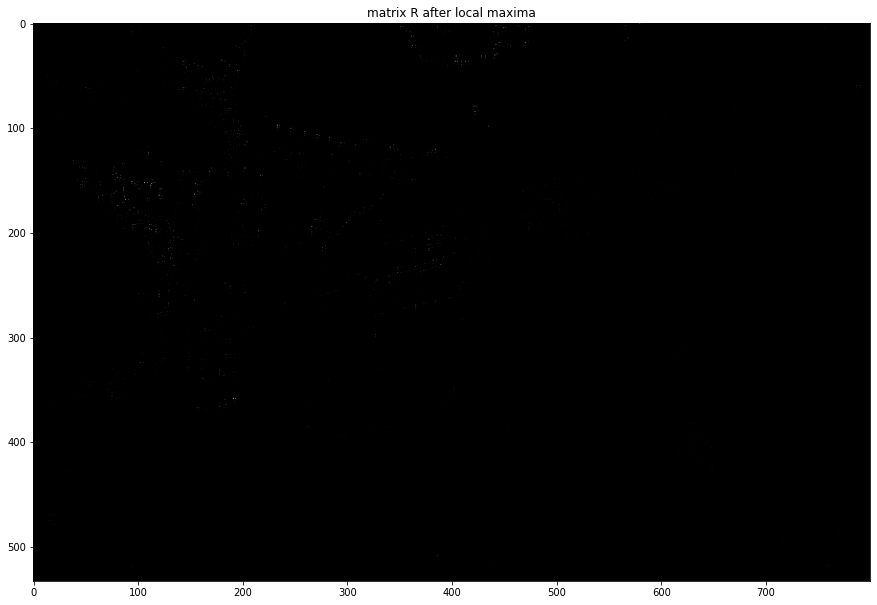

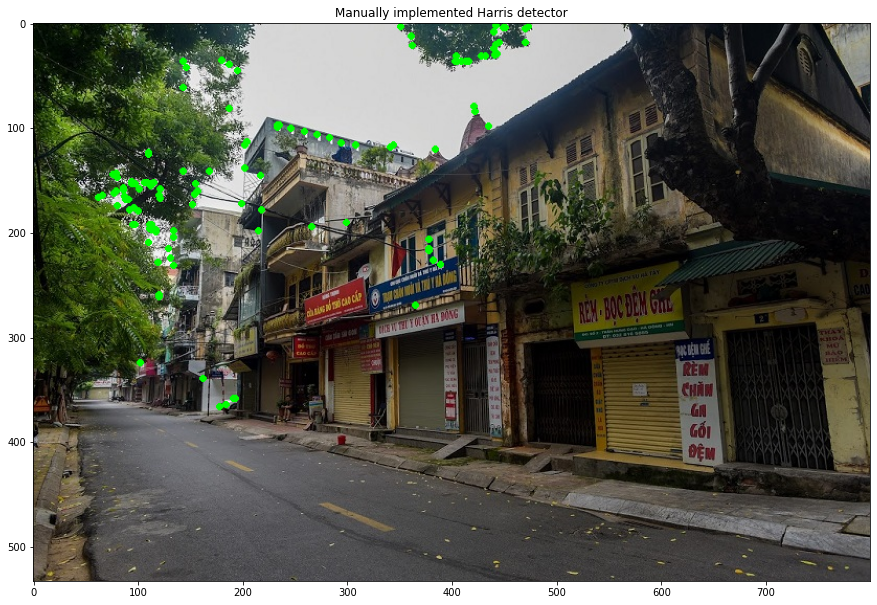

In [8]:
findHarrisCorners(img, 5, 0.04, 0.2)

Count:  61


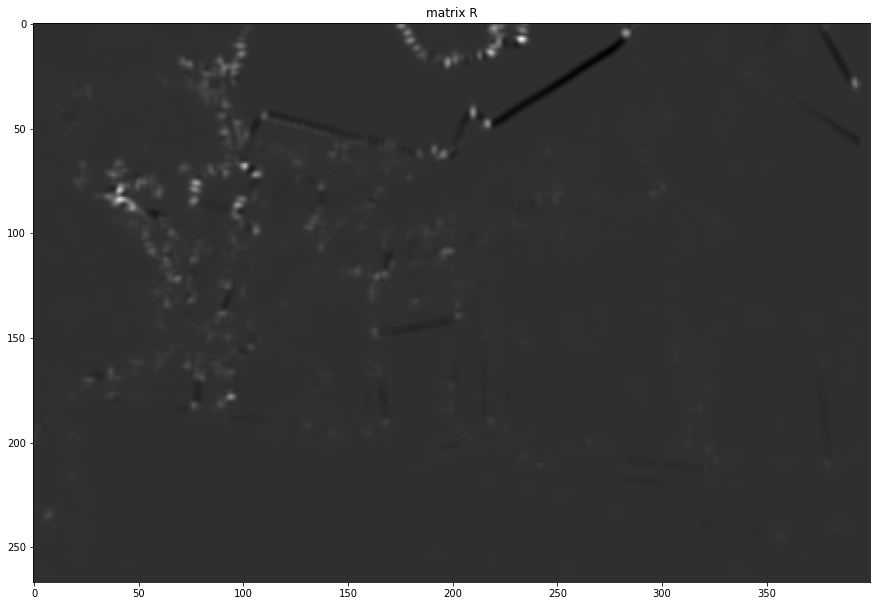

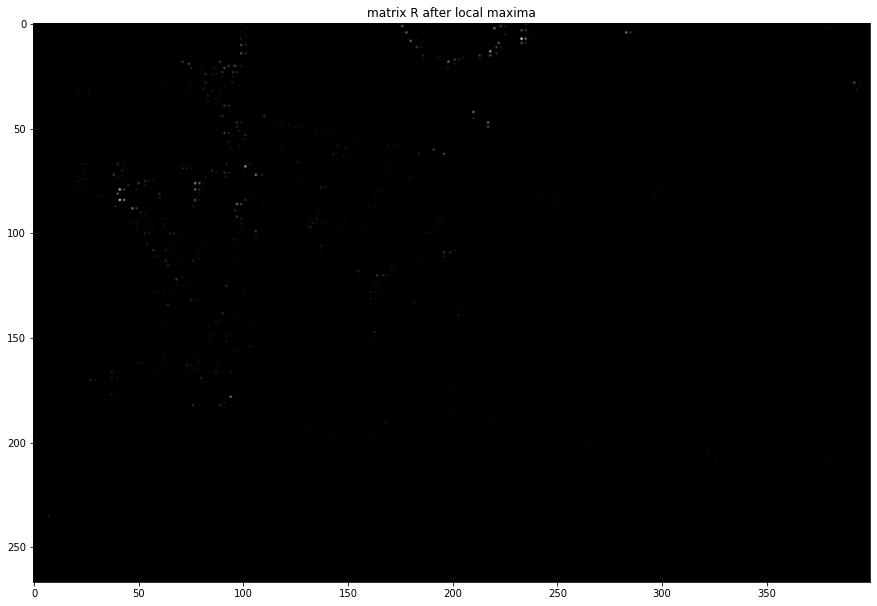

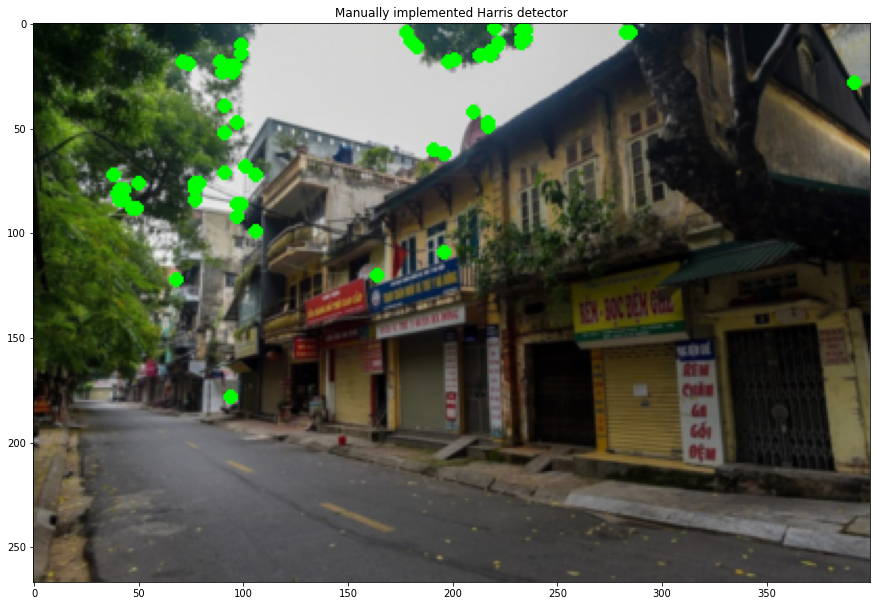

In [9]:
findHarrisCorners(imgDownScale, 5, 0.04, 0.2)

Count:  191


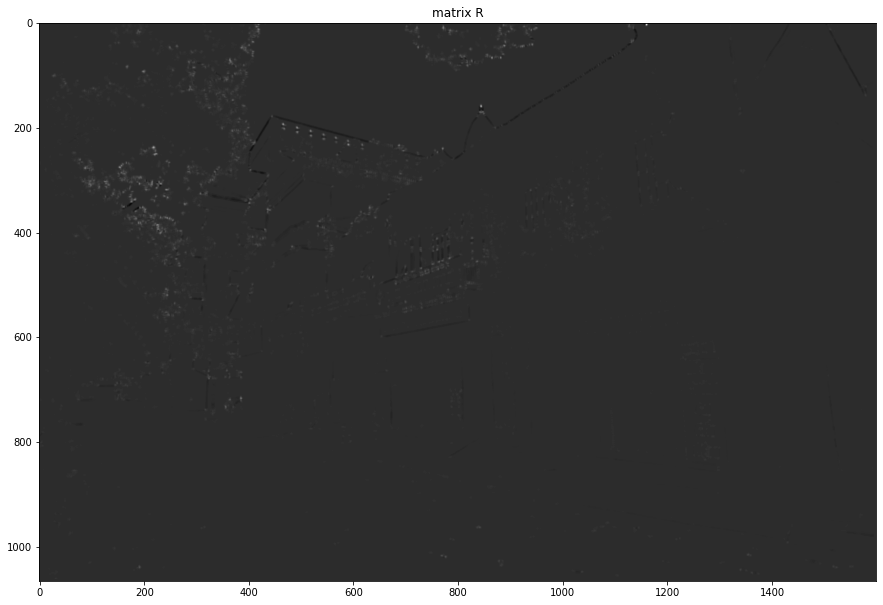

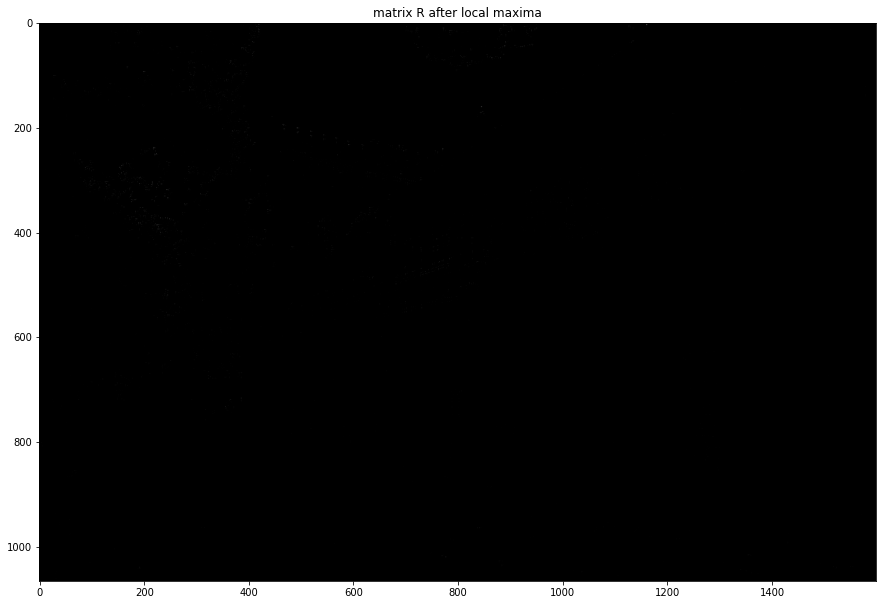

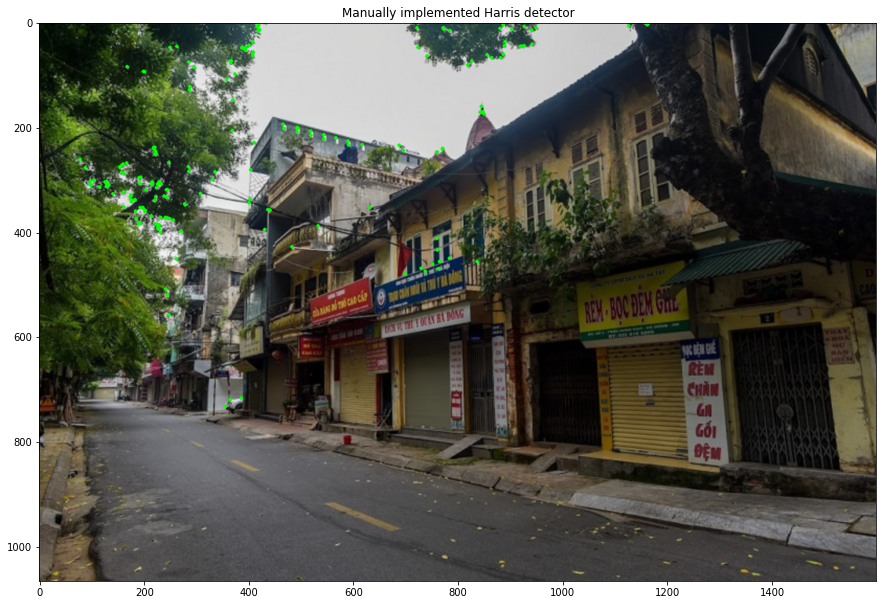

In [10]:
findHarrisCorners(imgUpScale, 5, 0.04, 0.2)